# GNN-Inductive- Link Prediction

In [27]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from torch_geometric.datasets import Reddit, PPI, Planetoid
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
from torch_geometric.data import NeighborSampler
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data
import logging
import time


## Define the dataset, the type of prediction and the number of samples

In [28]:
DATASET = 'cora'
PREDICTION = 'link'
RUN_COUNT = 1
NUM_SAMPLES = 1
PATH_TO_DATASETS_DIRECTORY = './'

In [29]:
datasets = {
    'reddit': Reddit(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Reddit'),
    'cora' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/Cora/', name='Cora'),
    'citeseer' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/CiteSeer/', name='CiteSeer'),
    'pubmed' : Planetoid(root=PATH_TO_DATASETS_DIRECTORY + '/datasets/PubMed/', name='PubMed'),
}
dataset = datasets[DATASET]
data = dataset[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [30]:
print("Printing Dataset Characteristics")
print("Name: ", DATASET)
print("Total Number of Nodes: ", data.num_nodes)
print("Total Number of Training Nodes: ", data.train_mask.sum().item())
print("Total Number of Val Nodes: ", data.val_mask.sum().item())
print("Total Number of Test Nodes: ", data.test_mask.sum().item())
print("Num Node Features: ", data.num_features)
print("Num Node Classes: ", dataset.num_classes)
print("Number of Edges: ", data.edge_index.shape[1])
print("Number of Samples for structural: ", NUM_SAMPLES)
print("Prediction Type: ", PREDICTION)

Printing Dataset Characteristics
Name:  cora
Total Number of Nodes:  2708
Total Number of Training Nodes:  140
Total Number of Val Nodes:  500
Total Number of Test Nodes:  1000
Num Node Features:  1433
Num Node Classes:  7
Number of Edges:  10556
Number of Samples for structural:  1
Prediction Type:  link


In [31]:
#data.train_mask = 1 - data.val_mask - data.test_mask
data.train_mask = ~(data.val_mask + data.test_mask)

adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
edges = data.edge_index.t()
adj_mat[edges[:,0], edges[:,1]] = 1

## Build the non-overlapping induced subgraphs

In [32]:
adj_train = adj_mat[data.train_mask].t()[data.train_mask].t()
adj_validation = adj_mat[data.val_mask].t()[data.val_mask].t()
adj_test = adj_mat[data.test_mask].t()[data.test_mask].t()

## Corrupt a small fraction of the edges

In [33]:
def corrupt_adj(adj_mat, task, percent=2):
    """ Returns the corrupted version of the adjacency matrix """
    if task == 'link':
        edges = adj_mat.triu().nonzero()
        num_edges = edges.shape[0]
        num_to_corrupt = int(percent/100.0 * num_edges)
        random_corruption = np.random.randint(num_edges, size=num_to_corrupt)
        adj_mat_corrupted = adj_mat.clone()
        false_edges, false_non_edges = [], []
        #Edge Corruption
        for ed in edges[random_corruption]:
            adj_mat_corrupted[ed[0], ed[1]] = 0
            adj_mat_corrupted[ed[1], ed[0]] = 0
            false_non_edges.append(ed.tolist())
        #Non Edge Corruption
        random_non_edge_corruption = list(np.random.randint(adj_mat.shape[0], size = 6*num_to_corrupt))
        non_edge_to_corrupt = []
        for k in range(len(random_non_edge_corruption)-1):
            to_check = [random_non_edge_corruption[k], random_non_edge_corruption[k+1]]
            if to_check not in edges.tolist():
                non_edge_to_corrupt.append(to_check)
            if len(non_edge_to_corrupt) == num_to_corrupt:
                break
        non_edge_to_corrupt = torch.Tensor(non_edge_to_corrupt).type(torch.int16)
        for n_ed in non_edge_to_corrupt:
            adj_mat_corrupted[n_ed[0], n_ed[1]] = 1
            adj_mat_corrupted[n_ed[1], n_ed[0]] = 1
            false_edges.append(n_ed.tolist())
    return adj_mat_corrupted, false_edges, false_non_edges


In [34]:
adj_train_corrupted, train_false_edges, train_false_non_edges = corrupt_adj(adj_train, 'link', percent=2)
adj_val_corrupted, val_false_edges, val_false_non_edges = corrupt_adj(adj_validation, 'link', percent=2)
adj_test_corrupted, test_false_edges, test_false_non_edges  = corrupt_adj(adj_test, 'link', percent=2)

# print(adj_train_corrupted)
# print(len(train_false_edges))
# print(len(train_false_non_edges))

#print(len(adj_train.nonzero())+len(adj_validation.nonzero())+len(adj_test.nonzero()))

## Define the GNN network

In [35]:
num_neurons = 256
input_rep = data.num_features

from torch_geometric.nn import GCNConv,GATConv,SAGEConv, GINConv
GNNlayer=GCNConv

class JointGNN(nn.Module):
    def __init__(self):
        super(JointGNN, self).__init__()
        
        self.GNN_layer1 = GNNlayer(input_rep,num_neurons)
        self.GNN_layer2 = GNNlayer(num_neurons,num_neurons)
        
        self.linear1 = nn.Linear(num_neurons,num_neurons)
        self.linear2 = nn.Linear(num_neurons,2)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x_feature, subgraphs, nodes, edges):
        
        
        node_tensor = torch.zeros((len(nodes), num_neurons)).to(device)
        node_count = torch.zeros((len(nodes)),requires_grad=False).to(device)

        
        for i in range(len(subgraphs)):
        
            graph=subgraphs[i]
            
            x=x_feature[i]
            x=self.GNN_layer1(x,graph.edge_index)
            x=self.relu(x)
            
            x=self.GNN_layer2(x,graph.edge_index)
            x=self.relu(x)
            
            for n_id in graph.b_id:                            
                sub_index=(graph.n_id==n_id).nonzero()[0]
                sub_x=x[sub_index,:]
                
                node_index=(nodes==n_id).nonzero()[0]
                
                node_count[node_index]+=1
                node_tensor[node_index,:]+=sub_x.view(-1)
                    
        node_tensor=node_tensor / node_count[:, None]
        
        z_tensor = torch.zeros((len(edges), num_neurons)).to(device)
        
        link_no=0
        for edge in edges:
            u=(nodes==edge[0]).nonzero()[0]
            v=(nodes==edge[1]).nonzero()[0]
            
            z_tensor[link_no,:]=(node_tensor[u,:]*node_tensor[v,:]).view(-1)
            link_no+=1
        
        
        #One Hidden Layer for predictor
        z_tensor = self.linear1(z_tensor)
        z_tensor = self.relu(z_tensor)
        z_tensor = self.linear2(z_tensor)
        
        return z_tensor

    def compute_loss(self, x_feature, subgraphs, nodes, edges, target):
        
        pred = self.forward(x_feature, subgraphs, nodes, edges)
        
        return F.cross_entropy(pred, target)
    
    def predict(self, x_feature, subgraphs, nodes, edges, target):
        
        pred = self.forward(x_feature, subgraphs, nodes, edges)        
        loss = F.cross_entropy(pred, target)
        
        return loss, pred
        
        

## Sample positive and negative edges

In [36]:
def sample_equal_number_edges_non_edges(adj_mat, false_non_edges, false_edges, small_samples):
    edges = adj_mat.nonzero()
    num_edges = edges.shape[0]
    inverse_adj_mat = 1 - adj_mat
    non_edges = inverse_adj_mat.nonzero()
    num_non_edges  = non_edges.shape[0]
    edges_sampled = edges[np.random.randint(num_edges, size=small_samples)]
    non_edges_sampled = non_edges[np.random.randint(num_non_edges, size=small_samples)]
    final_edges = []
    final_non_edges = []
    for ed in edges_sampled.tolist():
        if ed not in false_edges:
            final_edges.append(ed)
    final_edges += false_non_edges
    for n_ed in non_edges_sampled.tolist():
        if n_ed not in false_non_edges:
            final_non_edges.append(n_ed)
    final_non_edges += false_edges

    return final_edges, final_non_edges

## Minibatch of edges

In [37]:
class MiniBatcher(object):
    def __init__(self, batch_size, n_examples, shuffle=True):
        assert batch_size <= n_examples, "Error: batch_size is larger than n_examples"
        self.batch_size = batch_size
        self.n_examples = n_examples
        self.shuffle = shuffle
        logging.info("batch_size={}, n_examples={}".format(batch_size, n_examples))

        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0

    def get_one_batch(self):
        self.idxs = np.arange(self.n_examples)
        if self.shuffle:
            np.random.shuffle(self.idxs)
        self.current_start = 0
        while self.current_start < self.n_examples:
            batch_idxs = self.idxs[self.current_start:self.current_start+self.batch_size]
            self.current_start += self.batch_size
            yield torch.LongTensor(batch_idxs)

## Prediction

In [38]:
def predict_model(model,G_data, neighbor_sampler, minibatch_size, small_samples, adj_corrupted, false_non_edges, false_edges):
    
    preds=np.array([])
    targets=np.array([])
    total_loss=0
    
    edges, non_edges = sample_equal_number_edges_non_edges(adj_corrupted, false_non_edges, false_edges, small_samples)    
    samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
    true_target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
    
    batcher = MiniBatcher(minibatch_size, len(samples)) if minibatch_size > 0 else MiniBatcher(len(samples), len(samples))
    
    t_start = time.time()
    
    with torch.no_grad():
        for x_idxs in batcher.get_one_batch():
            x_idxs = x_idxs.to(device)

            x_edges=samples[x_idxs]
            y_target=true_target[x_idxs]

            nodes=torch.flatten(x_edges)            
            neighbor_graph=neighbor_sampler(nodes.cpu())
        
            x_feature=[]
            subgraphs=[]

            for graph in neighbor_graph:

                sub_nodes=graph.n_id
                sub_edges=graph.e_id
            
                x_feature.append(torch.Tensor(G_data.x[sub_nodes]).to(device))
                subgraphs.append(graph.to(device))

            loss, pred=model.predict(x_feature, subgraphs, nodes, x_edges, y_target)                          
            total_loss+=loss.item()
            
            pred = F.log_softmax(pred, dim=1)
            pred = pred.detach().to("cpu").numpy()
            pred = np.argmax(pred, axis=1)
                          
            preds = np.append(preds,pred)
            targets = np.append(targets,y_target.detach().to("cpu").numpy())
        

    micro=f1_score(targets, preds, average='micro')
    weighted=f1_score(targets, preds, average='weighted')
    acc=accuracy_score(targets, preds)
        
#     print("Micro F1 Score: ", micro )
#     print("Weighted F1 Score: ", weighted)
#     print("Accuracy Score: ", acc)
    
    
    return total_loss, acc, micro, weighted

## Plot Accuracy and Loss 

In [39]:
def save_plot(train_data, valid_data, name='Loss'):
    """Plot
        Plot one figure: accurace/loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_data)
    xs = np.arange(n)

    # plot train and test accuracies
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_data, '--', linewidth=2, label='train')
    ax.plot(xs, valid_data, '-', linewidth=2, label='valid')
    ax.set_xlabel("Epoch")
    ax.set_ylabel(name)
    ax.legend(loc='lower right')
    plt.show()
    plt.savefig('train_valid_'+name+'.png')

## Train the model

Minibatch time:  2.3826546669006348
Saving model Validation accuracy:  0.49754901960784315
----------------------------------------------------------------------------------------------------
[Epoch 0] Train Loss: 157.14372904598713, Train Accuracy: 0.5640449438202247, Val Loss 141.4318247437477, Val Accuracy: 0.49754901960784315
Minibatch time:  2.2680044174194336
----------------------------------------------------------------------------------------------------
[Epoch 1] Train Loss: 153.2323256880045, Train Accuracy: 0.5650224215246636, Val Loss 141.12921726703644, Val Accuracy: 0.4963144963144963
Minibatch time:  2.2291038036346436
Saving model Validation accuracy:  0.538083538083538
----------------------------------------------------------------------------------------------------
[Epoch 2] Train Loss: 140.2149637490511, Train Accuracy: 0.6741573033707865, Val Loss 136.52166706323624, Val Accuracy: 0.538083538083538
Minibatch time:  2.650059461593628
Saving model Validation accur

Minibatch time:  3.1756575107574463
----------------------------------------------------------------------------------------------------
[Epoch 28] Train Loss: 58.398418471217155, Train Accuracy: 0.9260089686098655, Val Loss 104.19146327674389, Val Accuracy: 0.7660098522167488
Minibatch time:  3.2365834712982178
----------------------------------------------------------------------------------------------------
[Epoch 29] Train Loss: 54.17864382266998, Train Accuracy: 0.9260089686098655, Val Loss 111.97199584543705, Val Accuracy: 0.769041769041769
Minibatch time:  3.584390640258789
----------------------------------------------------------------------------------------------------
[Epoch 30] Train Loss: 45.868550941348076, Train Accuracy: 0.9324324324324325, Val Loss 160.9166178703308, Val Accuracy: 0.6724137931034483
Minibatch time:  3.3904614448547363
----------------------------------------------------------------------------------------------------
[Epoch 31] Train Loss: 54.1226399

<Figure size 432x288 with 0 Axes>

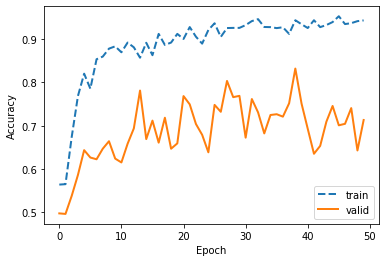

<Figure size 432x288 with 0 Axes>

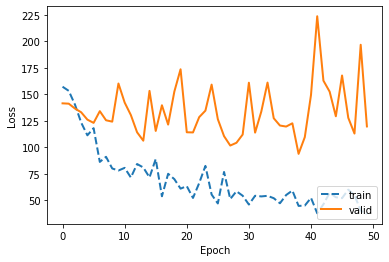

<Figure size 432x288 with 0 Axes>

In [40]:
gnn_model = JointGNN().to(device)
gnn_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001)
gnn_best_model = 'best_gnn_inductive_model.model'


epochs = 50
validation_acc = 0
small_samples = 200

G_train=Data(edge_index=(adj_train_corrupted.nonzero()).t(), x=data.x[data.train_mask])
G_val=Data(edge_index=(adj_val_corrupted.nonzero()).t(), x=data.x[data.val_mask])
G_test=Data(edge_index=(adj_test_corrupted.nonzero()).t(), x=data.x[data.test_mask])

minibatch_size=2
k=5
hop=2

train_neighbor_sampler=NeighborSampler(G_train,size=k,num_hops=hop,bipartite=False,batch_size=2*minibatch_size)
val_neighbor_sampler=NeighborSampler(G_val,size=k,num_hops=hop,bipartite=False,batch_size=2*minibatch_size)
test_neighbor_sampler=NeighborSampler(G_test,size=k,num_hops=hop,bipartite=False,batch_size=2*minibatch_size)


train_accs=[]
val_accs=[]
train_losses=[]
val_losses=[]


for num_epoch in range(epochs):
            
    edges, non_edges = sample_equal_number_edges_non_edges(adj_train_corrupted, false_non_edges=train_false_non_edges, false_edges=train_false_edges, small_samples=small_samples)
    
    samples = torch.cat((torch.Tensor(edges), torch.Tensor(non_edges)),dim=0).type(torch.long).to(device)
    target = torch.cat((torch.ones(len(edges)), torch.zeros(len(non_edges))),dim=0).type(torch.long).to(device)
    
    
    train_batcher = MiniBatcher(minibatch_size, len(samples)) if minibatch_size > 0 else MiniBatcher(len(samples), len(samples))
    
    train_loss=0
    y_pred=[]
    y_true=[]
    
    t_start = time.time()
    for train_idxs in train_batcher.get_one_batch():
        train_idxs = train_idxs.to(device)
        
        train_edges=samples[train_idxs]
        train_target=target[train_idxs]

        nodes=torch.flatten(train_edges)
        neighbor_graph=train_neighbor_sampler(nodes.cpu())
        
        x_feature=[]
        subgraphs=[]
        
        for graph in neighbor_graph:
                
            sub_nodes=graph.n_id
            sub_edges=graph.e_id
            
            x_feature.append(torch.Tensor(G_train.x[sub_nodes]).to(device))
            subgraphs.append(graph.to(device))
        
        gnn_optimizer.zero_grad()        
        
        #loss=gnn_model.compute_loss(x_feature, subgraphs, nodes, train_edges, train_target)
        loss, pred=gnn_model.predict(x_feature, subgraphs, nodes, train_edges, train_target)
        
        loss.backward()
        gnn_optimizer.step()
        
        train_loss+=loss.item()
            
        pred = F.log_softmax(pred, dim=1)
        pred = pred.detach().to("cpu").numpy()
        pred = np.argmax(pred, axis=1)

        y_pred = np.append(y_pred,pred)
        y_true = np.append(y_true,train_target.detach().to("cpu").numpy())
        
    
    t_end= time.time()
    print("Minibatch time: ",t_end-t_start)
    
    train_acc=accuracy_score(y_true, y_pred)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_loss,val_acc,_,_=predict_model(gnn_model,G_val, val_neighbor_sampler, minibatch_size, small_samples, adj_val_corrupted, val_false_non_edges, val_false_edges)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_acc > validation_acc:
            validation_acc = val_acc
            print("Saving model Validation accuracy: ", validation_acc)
            #Save Model
            torch.save(gnn_model.state_dict(), gnn_best_model)
    
    print("-"*100)
    print("[Epoch {0}] Train Loss: {1}, Train Accuracy: {2}, Val Loss {3}, Val Accuracy: {4}".format(num_epoch, train_loss, train_acc, val_loss, val_acc))
    
        
save_plot(train_accs, val_accs, name='Accuracy')
save_plot(train_losses, val_losses, name='Loss')        

## Forward pass on the test graphs

In [41]:
gnn_best_model = 'best_gnn_inductive_model.model'
gnn_model = JointGNN().to(device)
gnn_model.load_state_dict(torch.load(gnn_best_model))

_,test_acc,test_micro,test_weighted=predict_model(gnn_model,G_test, test_neighbor_sampler, minibatch_size, small_samples, adj_test_corrupted, test_false_non_edges, test_false_edges)

print("Test Micro F1 Score: ", test_micro)
print("Test Weighted F1 Score: ", test_weighted)
print("Test Accuracy Score: ", test_acc)

Test Micro F1 Score:  0.7594339622641509
Test Weighted F1 Score:  0.753641287863306
Test Accuracy Score:  0.7594339622641509


## Scratch

In [42]:
train_batcher = MiniBatcher(2, 10) if minibatch_size > 0 else MiniBatcher(10, 10)

for i in range(3):
    for train_idxs in train_batcher.get_one_batch():
        print(train_idxs)
    print("")


tensor([0, 5])
tensor([9, 1])
tensor([3, 8])
tensor([6, 2])
tensor([4, 7])

tensor([8, 9])
tensor([3, 5])
tensor([4, 7])
tensor([1, 2])
tensor([0, 6])

tensor([0, 8])
tensor([1, 9])
tensor([2, 4])
tensor([5, 6])
tensor([3, 7])

